In [1]:
import pandas as pd
import numpy as np
from lmfit import minimize, Parameters

In [2]:
import matplotlib as mpl 
mpl.use('Agg')
import matplotlib.pyplot as plt 
from matplotlib import rcParams
%matplotlib inline

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

# Importing Moustakas data points

In [21]:
path='/home/users/staudt/projects/mergers/data/moustakas_smf_points.txt'
nams=['zlo','zhi','ngal','mass','limit',
        'phi','phierr_lo','phierr_up','phierr_cv']
df=pd.read_fwf(path,header=None,names=nams,skiprows=20)

log_ms=np.array(df['mass'])
dndlogm_dat=10.**np.array(df['phi'])
#error in dndlogm from observational data
d_dat=10.**np.array(df['phi'])*np.log(10.)*np.array(df['phierr_cv'])
zlos=np.array(df['zlo'])
zhis=np.array(df['zhi'])

#Get z ranges:
zlos_set=np.sort(list(set(zlos)))
zhis_set=np.sort(list(set(zhis)))
z_rngs=np.transpose(np.append([zlos_set],[zhis_set],axis=0))

# Defining the Schecter function and the residual function

In [56]:
def schecter_f(p,log_ms):
    amp=p['amp'].value
    log_mchar=p['log_mchar'].value
    slope=p['slope'].value
    mrats=10.**(log_ms-log_mchar)
    dndlogm=np.log(10.)*amp*mrats**(1.+slope)*np.exp(-mrats)
    return dndlogm
def resids_f(params,log_ms,data,d_data):
    #formula to get weighted residuals for lmfit
    y=schecter_f(params,log_ms)
    resids=y-data
    w_resids=resids/d_data #weighted residuals
    if np.inf in w_resids:
        print [params[key].value for key in params.keys()]
    return w_resids

# Performing the fits

In [132]:
def plt_fts(ax,log_ms,Ys,dYs,p,zrng,redchisq):
    log_ms_fit=np.linspace(7,13,200)
    ys=schecter_f(p,log_ms_fit)
    
    ax.errorbar(log_ms,Ys,dYs,
                fmt='o',color='r',elinewidth=0.9,
                capsize=3,ecolor='k',ms=3)
    ax.plot(log_ms_fit,ys)
    ax.set_yscale('log')
    ax.set_ylim(1e-7,1e-1)
    ax.set_xlim(8.7,12.3)
    
    ax.text(0.7,0.1,'$z=${0:0.2f}~{1:0.2f}\n$\chi_\mathrm{{r}}^2={2:0.2f}$'\
            .format(zrng[0],zrng[1],redchisq),
            fontsize=20,horizontalalignment='right',
            verticalalignment='bottom',transform=ax.transAxes,
            bbox=dict(facecolor='white',alpha=0.7,edgecolor='none'))

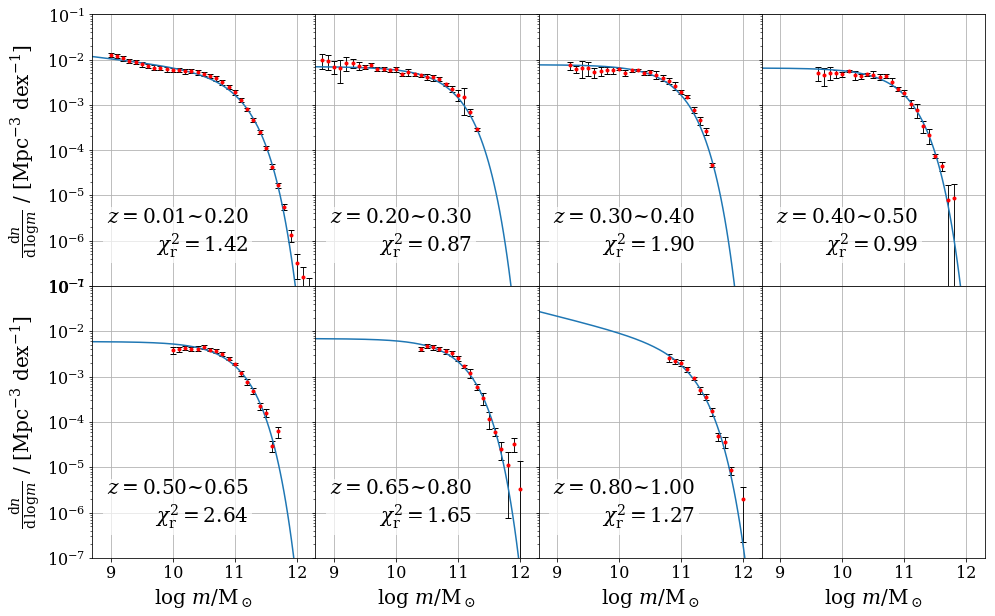

In [140]:
params=Parameters()
params.add('amp',value=5.e-3,vary=True,min=0.)
params.add('log_mchar',value=10.5,vary=True,min=0.,max=20.)
params.add('slope',value=-1.5,vary=True,min=-10.,max=-1.)

#initialize parameter lists
amp_fits=[]
log_mchar_fits=[]
slope_fits=[]

fig,axs=plt.subplots(2,4,figsize=(16,10),sharex=True,sharey=True)
axs=axs.ravel()
fig.subplots_adjust(wspace=0.,hspace=0.)

for axi,zrng in enumerate(z_rngs):
    inrng=(zlos==zrng[0])&(zhis==zrng[1])
    log_ms_z=log_ms[inrng]
    dndlogm_dat_z=dndlogm_dat[inrng]
    d_dat_z=d_dat[inrng]
    
    fit=minimize(resids_f,params,args=(log_ms_z,dndlogm_dat_z,d_dat_z))
    amp_fits+=[fit.params['amp'].value]
    log_mchar_fits+=[fit.params['log_mchar'].value]
    slope_fits+=[fit.params['slope'].value]
    
    plt_fts(axs[axi],log_ms_z,dndlogm_dat_z,d_dat_z,fit.params,zrng,fit.redchi)

for i in [0,4]:
    axs[i].set_ylabel('$\\frac{\mathrm{d}n}{\mathrm{d\,log}m}$ / [Mpc$^{-3}$ dex$^{-1}$]')
for i in [4,5,6,7]:
    axs[i].set_xlabel('log $m/$M$_\odot$')
    
plt.show()

## Printing the results

In [157]:
np.set_printoptions(formatter={'float': lambda x: format(x,'0.4f')})

print('redshifts:')
print(np.mean(z_rngs,axis=1))

print('\nlog m_chars:')
print np.array(log_mchar_fits)

print('\namplitudes x 10^4:')
print(repr(np.array(amp_fits)*1.e4))

print('\nslopes:')
print(repr(np.array(slope_fits)))

redshifts:
[0.1050 0.2500 0.3500 0.4500 0.5750 0.7250 0.9000]

log m_chars:
[10.9582 10.8101 10.8103 10.8612 10.9114 10.9310 11.0315]

amplitudes x 10^4:
array([22.0555, 29.4359, 33.3472, 28.2186, 25.7530, 30.0008, 19.1025])

slopes:
array([-1.1604, -1.0059, -1.0000, -1.0000, -1.0000, -1.0000, -1.3417])


# Trying a double Schechter function

In [65]:
def dbl_schecter_f(p,log_ms):
    log_mchar=p['log_mchar'].value    
    amp1=p['amp1'].value
    amp2=p['amp2'].value
    slope1=p['slope1'].value
    slope2=p['slope2'].value
    mrats=10.**(log_ms-log_mchar)
    dndlogm=np.log(10.)*np.exp(-mrats)*(amp1*mrats**(1.+slope1)+amp2*mrats**(1.+slope2))
    return dndlogm
def dbl_resids_f(params,log_ms,data,d_data):
    #formula to get weighted residuals for lmfit
    y=dbl_schecter_f(params,log_ms)
    resids=y-data
    w_resids=resids/d_data #weighted residuals
    if np.inf in w_resids:
        print [params[key].value for key in params.keys()]
    return w_resids

In [142]:
def plt_dbl_fts(ax,log_ms,Ys,dYs,p,zrng,redchisq):
    log_ms_fit=np.linspace(7,13,200)
    ys=dbl_schecter_f(p,log_ms_fit)
    
    ax.errorbar(log_ms,Ys,dYs,
                fmt='o',color='r',elinewidth=0.9,
                capsize=3,ecolor='k',ms=3)
    ax.plot(log_ms_fit,ys)
    ax.set_yscale('log')
    ax.set_ylim(1e-7,1e-1)
    ax.set_xlim(8.7,12.3)
    
    ax.text(0.7,0.1,'$z=${0:0.2f}~{1:0.2f}\n$\chi_\mathrm{{r}}^2={2:0.2f}$'\
            .format(zrng[0],zrng[1],redchisq),
            fontsize=20,horizontalalignment='right',
            verticalalignment='bottom',transform=ax.transAxes,
            bbox=dict(facecolor='white',alpha=0.7,edgecolor='none'))

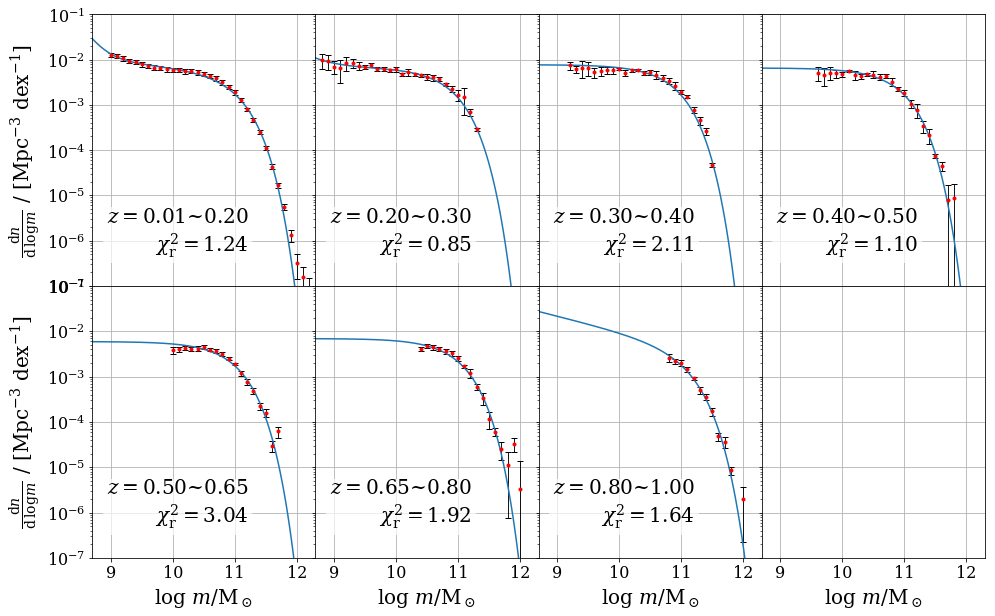

In [143]:
params=Parameters()
params.add('amp1',value=5.e-3,vary=True,min=0.)
params.add('amp2',value=5.e-3,vary=True,min=0.)
params.add('log_mchar',value=10.5,vary=True,min=0.,max=20.)
params.add('slope1',value=-1.5,vary=True,min=-10.,max=-1.)
params.add('slope2',value=-1.5,vary=True,min=-10.,max=-1.)

#initialize parameter lists
amp1_fits=[]
amp2_fits=[]
log_mchar_dbl_fits=[]
slope1_fits=[]
slope2_fits=[]

fig,axs=plt.subplots(2,4,figsize=(16,10),sharex=True,sharey=True)
axs=axs.ravel()
fig.subplots_adjust(wspace=0.,hspace=0.)

for axi,zrng in enumerate(z_rngs):
    inrng=(zlos==zrng[0])&(zhis==zrng[1])
    log_ms_z=log_ms[inrng]
    dndlogm_dat_z=dndlogm_dat[inrng]
    d_dat_z=d_dat[inrng]
    
    fit=minimize(dbl_resids_f,params,args=(log_ms_z,dndlogm_dat_z,d_dat_z))
    amp1_fits+=[fit.params['amp1'].value]
    amp2_fits+=[fit.params['amp2'].value]
    log_mchar_dbl_fits+=[fit.params['log_mchar'].value]
    slope1_fits+=[fit.params['slope1'].value]
    slope2_fits+=[fit.params['slope2'].value]
    
    plt_dbl_fts(axs[axi],log_ms_z,dndlogm_dat_z,d_dat_z,fit.params,zrng,fit.redchi)
    
for i in [0,4]:
    axs[i].set_ylabel('$\\frac{\mathrm{d}n}{\mathrm{d\,log}m}$ / [Mpc$^{-3}$ dex$^{-1}$]')
for i in [4,5,6,7]:
    axs[i].set_xlabel('log $m/$M$_\odot$')

plt.show()